# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 17

**Author 1 (sciper):** Ben Haj Yahia AHMED (261317)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

## Part 0: Helper functions

This section contains two functions that are repeatedly used in this notebook, one to highlight the brain from the MRI scan and the other to display side by side a comparison between the original image and the segmentation method that is being tested.

In [145]:
def superimpose_mask(mask, img):
    """Plot a mask in red over the original image"""
    # Convert to [0, 1] range
    if mask.max() > 1:
        mask = mask / 255.0
    if img.max() > 1:
        img = img / 255.0
    
    # Construct RGB version of grey-level image 
    img_color = np.dstack((img, img, img))

    # Construct a colour image to superimpose
    color_mask = np.zeros((img.shape[0], img.shape[1], 3))
    color_mask[:,:,0] = mask

    # Add color mask to image
    alpha = 0.2
    img_masked = img_color + alpha * color_mask

    return img_masked

In [176]:
def segmentation_comparison_plot(images, titles):
    """
    images: list of images to plot side by side
    """

    # Crops and corresponding labels
    crops = [(range(0, 256), range(0, 256)),]

    # Define figure and titles
    fig, axs = plt.subplots(1, len(images), figsize=(len(images)*3+1, 11))
    for j in range(len(images)):
        axs[j].set_title(titles[j])

        
        axs[0].set_ylabel('Brain Image')
        axs[0].get_xaxis().set_ticks([])
        axs[0].get_yaxis().set_ticks([])
        
        for i in range(len(images)):

            axs[i].imshow(images[i], cmap='gray', vmin=0, vmax=255)
            if i > 0:
                axs[i].axis('off')

    plt.tight_layout()
    plt.show()

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

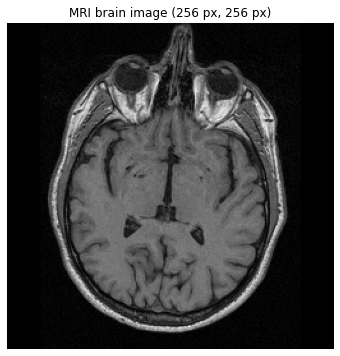

In [177]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im_path = os.path.join(data_path, 'brain-slice40.tiff')
brain_im = skimage.io.imread(brain_im_path)
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

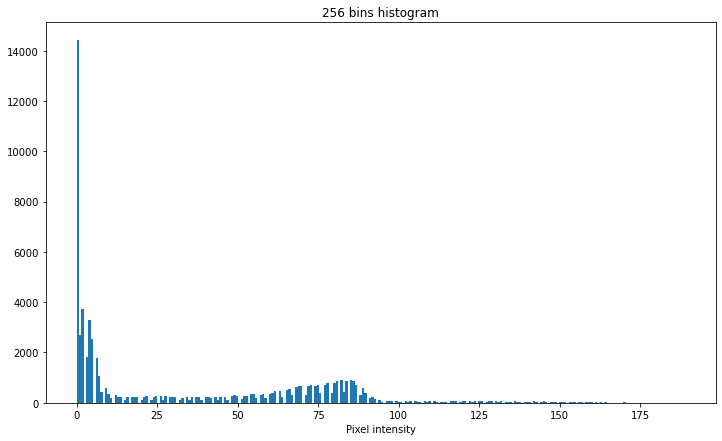

In [178]:
nb_bins = 256

# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(brain_im.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.title('256 bins histogram')

plt.show()

### 1.2 Region growing (5pts)

In [179]:
default_seed_location = (110, 110)

# Region growing criteria
# x is a pixel within the region, y a neighbour of x
def intensity_difference(x, y, img=None, region=None, threshold=5):
    return abs(x - y) <= threshold

def mean_intensity_difference(x, y, img=None, region=None, threshold=18):
    return abs(np.mean(img[region==1]) - y) <= threshold

def intensity_threshold(x, y, img=None, region=None, threshold_low=57, threshold_high=95):
    return (y >= threshold_low) and (y <= threshold_high)

# Region growing implementation
def region_growing(img, criterion=intensity_difference,
                   seed_location=default_seed_location):
    """Perform region growing with given homogeneity criterion.
    
    img: image to segment
    criterion: homogeneity criterion function for region growing
    seed_location: starting region (pixel) location
    """
    
    img = img.astype(np.int)
    
    # Function to extract neighbours from which to grow next
    def _get_neighbours(pixel, exclude):
        # Define neighbours
        min_row = max(0, pixel[0]-1)
        max_row = min(img.shape[0], pixel[0]+2)
        min_col = max(0, pixel[1]-1)
        max_col = min(img.shape[1], pixel[1]+2)
        
        # Add those, that are not yet part of the region
        neighbours = []
        for i in range(min_row, max_row):
            for j in range(min_col, max_col):
                if not exclude[i, j]:
                    neighbours.append((i, j))
                    
        return neighbours
        
    
    # Select center as starting point
    seed = seed_location
    
    # Perform region growing
    region = np.zeros_like(img) # store region
    seen = np.zeros_like(img) # those looked at
    region[seed] = 1            # 1 indicates already in region
    seen[seed] = 1  
    expand_list = [seed]        # list of pixels from which to grow next
    while expand_list:
        expand_pixel = expand_list.pop(0)
        neighbours = _get_neighbours(expand_pixel, region) #seen) 
        # Check for each neighbour, if it should be included into the region
        for neighbour in neighbours:
            seen[neighbour] = 1
            if criterion(img[expand_pixel], img[neighbour], img, region):
                region[neighbour] = 1
                expand_list.append(neighbour)
        
    return region * 255, np.sum(region)

In [180]:
# a) simple threshold
mask_intensity_thr, size_intensity = region_growing(brain_im, criterion=intensity_threshold)
mask_difference_thr, size_difference = region_growing(brain_im, criterion=intensity_difference)
mask_mean_difference_thr, size_mean_difference = region_growing(brain_im, criterion=mean_intensity_difference)

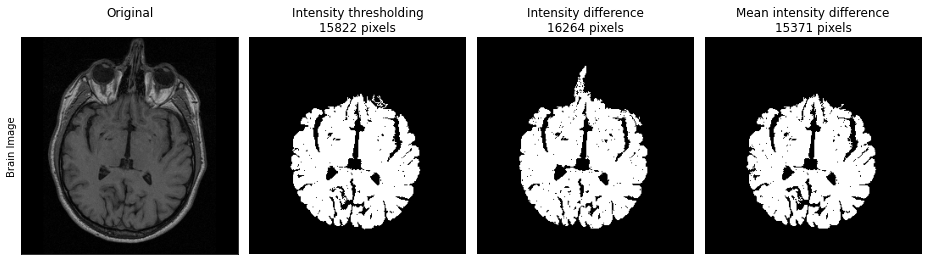

In [181]:
images = [brain_im, mask_intensity_thr, mask_difference_thr, mask_mean_difference_thr]
titles = ['Original\n',
          'Intensity thresholding\n{} pixels'.format(size_intensity),
          'Intensity difference\n{} pixels'.format(size_difference),
          'Mean intensity difference\n{} pixels'.format(size_mean_difference)]

segmentation_comparison_plot(images, titles)

### 1.3 Contour detection (5pts)

# Add your implementation and discussion

--> I think we need to preprocess the Image before applying the canny edge but I coulnd't find the appropriate preprocessing steps

In [199]:
from skimage.exposure import rescale_intensity
from skimage.morphology import erosion, remove_small_objects
import cv2

In [ ]:
#filter to get rid of the edge percentiles
p2, p98 = np.percentile(brain_im, (2, 98))
# Stretch the histogram to create more separation
eq_im = rescale_intensity(brain_im, in_range=(p2, p98))

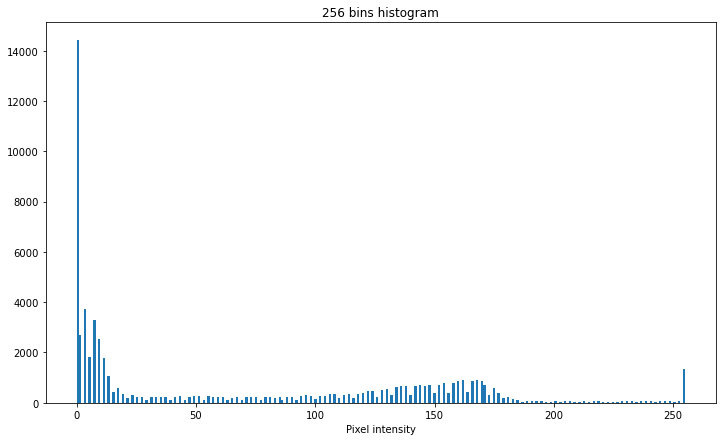

In [204]:
nb_bins = 256

# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(eq_im.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.title('256 bins histogram')

plt.show()

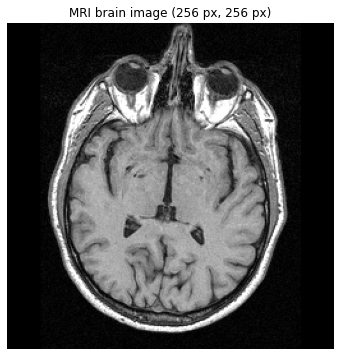

In [211]:
# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(eq_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [200]:
# Filter out the white regions representing the skull
filtered_im = eq_im.copy()
# Thresholds that are manually chosen to remove the skull and the dark grey area under the posterior cortex
filtered_im[(filtered_im>200) + (filtered_im<60)]=0

The code used for the following part mostly comes from: https://www.thepythoncode.com/article/contour-detection-opencv-python

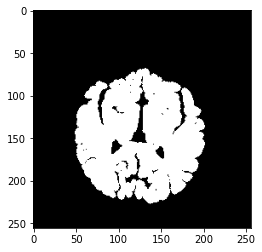

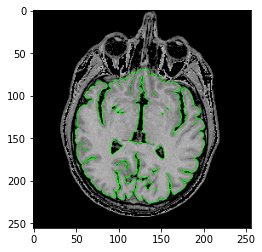

In [201]:
# convert to RGB
image_contours = cv2.cvtColor(filtered_im, cv2.COLOR_BGR2RGB)
# convert to grayscale
gray = cv2.cvtColor(image_contours, cv2.COLOR_RGB2GRAY)

# create a binary thresholded image
_, binary = cv2.threshold(gray, 85, 255, cv2.ADAPTIVE_THRESH_MEAN_C)

# show it
# Erode the thresholded image by using a disk with radius 3
erosion_brain = erosion(binary, selem=disk(3), out=None)>0
# Clean the images by removing image regions that are smaller than 400 pixels
cleaned_brain = remove_small_objects(erosion_brain, min_size=400, connectivity=1, in_place=False)
# Dilate the image around a disk with radius 4
dilation_brain = dilation(cleaned_brain, selem=disk(3), out=None)

dilation_br = 255*dilation_brain #erosion and dilation change the ndarray, 
                                  #so this line converts it back to 0 to 255 values

plt.imshow(dilation_brain, cmap="gray")
plt.show()

# find the contours from the thresholded image
contours, hierarchy = cv2.findContours(dilation_br.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# draw all contours
image_contours = cv2.drawContours(image_contours, contours, -1, (0, 255, 0), 1)

# show the image with the drawn contours
plt.imshow(image_contours)
plt.show()

In [219]:
large = 0
small = 0

# Calculation of the contour areas
for cont in range(len(contours)):
    x = cv2.contourArea(contours[cont])
    
    # Large contours are part of the brain
    if x > 10000:
        large += x
    # Small contours are natural empty space due to grooves of the brain
    else:
        small += x

brain_area = large-small

print('Brain area in pixels:',brain_area)

Brain area in pixels: 15988.5


### 1.4 Additional method (5pts)

The Watershed from sklearn library has a function (skimage.morphology.watershed()) that implements a region-growing approach that fills “basins” in the image. We choose to use it here. It is a method based on region growing. However, it is not exactly region the plain and simple region growing we implement in section 1.2.

In [4]:
from skimage import measure 
from skimage.exposure import histogram
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border, watershed
from scipy import ndimage as ndi
from skimage.filters.rank import median
from skimage.morphology import disk, area_opening, area_closing, dilation

#### Preprocessing

In [5]:
# Define object basins for the watershed algorithm identifying different objects
markers = np.zeros_like(brain_im)
markers[brain_im < 12.5] = 1
markers[brain_im > 65] = 2
markers[brain_im > 85] = 1

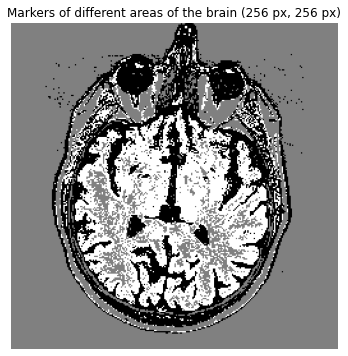

In [90]:
# Plot to visualize the separation between the objects
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(markers, cmap='gray')
ax.set_title('Markers of different areas of the brain ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [39]:
# Perform Segmentation using watershed algorithm
segmentation = watershed(brain_im, markers)

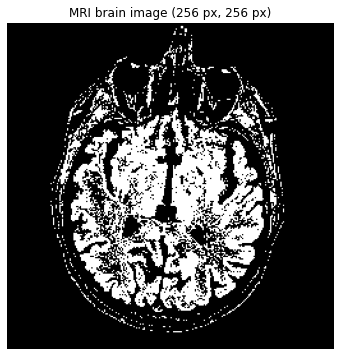

In [47]:
# Visualize the segmented image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(segmentation, cmap='gray')
ax.set_title('Segmented brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

#### <font color="red"> Note </font>

As we can the segmentation result was that we have noise shaped like the skull while the brain seems to be intact, with holes from the noise. Therefore, we have a nice separation between them so they can be easily removed with postprocessing.

#### Post Processing

In [86]:
# Perform area closing to plug the gaps in the brain
closed = area_closing(segmentation, 2048)

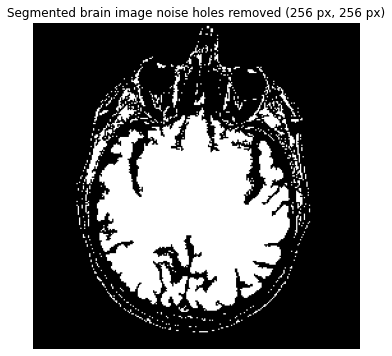

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(closed, cmap='gray')
ax.set_title('Segmented brain image noise holes removed ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [88]:
# Perform area opening to remove the skull shaped noise
opened = area_opening(closed, 256)

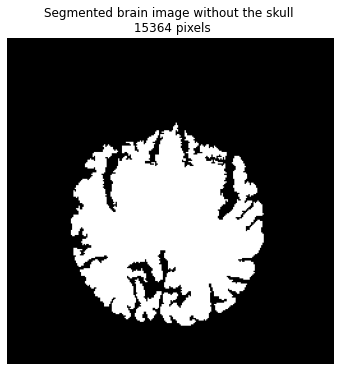

In [182]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(opened, cmap='gray')
ax.set_title('Segmented brain image without the skull \n {} pixels'.format((opened == 2).sum()))
ax.axis('off')
plt.show()

In [96]:
# Closing brain groves
dilated = dilation(opened, disk(5))

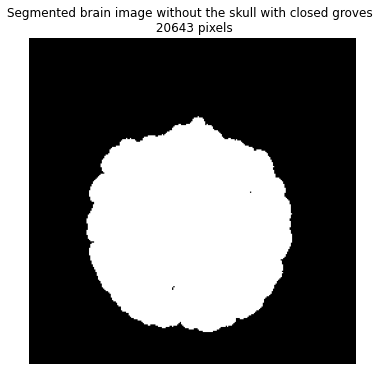

In [183]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(dilated, cmap='gray')
ax.set_title('Segmented brain image without the skull with closed groves \n {} pixels'.format((dilated == 2).sum()))
ax.axis('off')
plt.show()

#### Different preprocessing approach

Internal Marker


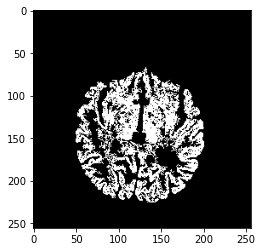

External Marker


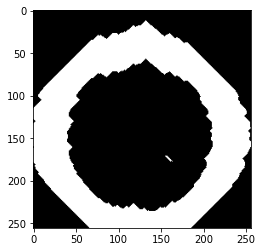

Watershed Marker


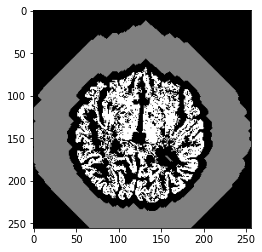

In [118]:
# Some of the starting Code is taken from ArnavJain, since it's more readable then my own
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = (image > 65) & (image < 85)
    marker_internal = clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    # We choose to create the two largest areas in the internal markers which are most of the brain and the posterior cortex
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker to outline the skull
    external_a = ndi.binary_dilation(marker_internal, iterations=10)
    external_b = ndi.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((256, 256), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(brain_im)
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

Sobel Gradient


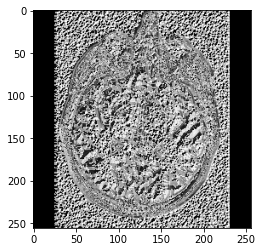

Watershed Image


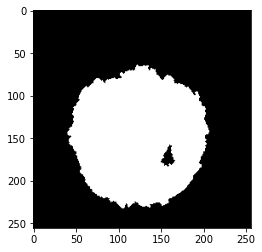

Outline after reinclusion


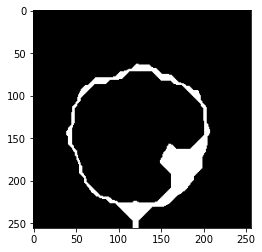

Skullfilter after closing


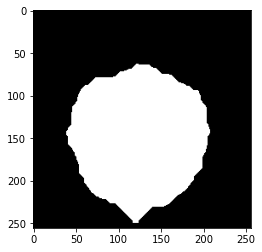

Segmented Lung


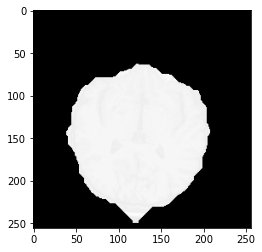

In [132]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndi.sobel(image, 1)
    sobel_filtered_dy = ndi.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    
    #Watershed algorithm
    watershed_res = watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndi.morphological_gradient(watershed_res, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndi.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndi.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the skullfilter
    skullfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the skullfilter
    #fill_holes is not used here
    skullfilter = ndi.morphology.binary_closing(skullfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the skullfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(skullfilter == 1, image, -2000*np.ones((256, 256)))
    
    return segmented, skullfilter, outline, watershed_res, sobel_gradient, marker_internal, marker_external, marker_watershed

#Some Testcode:
test_segmented, test_skullfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(brain_im)

print ("Sobel Gradient")
plt.imshow(np.rint(test_sobel_gradient).astype(int), cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Skullfilter after closing")
plt.imshow(test_skullfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(test_segmented, cmap='gray')
plt.show()

In [184]:
print('Area occupied by the brain without the skull with closed groves is {} pixels'.format((test_watershed == 255).sum()))

Area occupied by the brain without the skull with closed groves is 20287 pixels


#### <font color="red"> Note </font>

Using the sobel gradient smoothes the grooves in the brain, Therefore our segmentation looked like the earlier approach.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [31]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


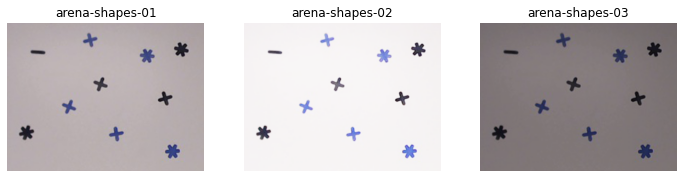

In [32]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

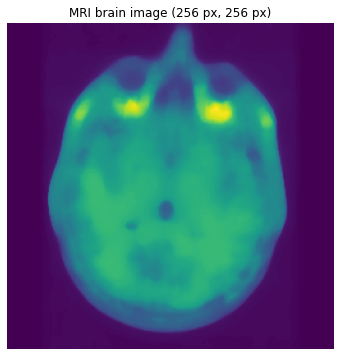

In [33]:
# Add your implementation and discussion
from skimage import filters
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value


img = images[0, :, :, :]

@adapt_rgb(each_channel)
def median_each(img):
    return filters.median(img, disk(10))


filtered  = median_each(image)


fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(filtered)
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

In [34]:
np.unique(filtered.reshape(-1, 3), axis=0).shape

ValueError: cannot reshape array of size 65536 into shape (3)

In [ ]:
markers = np.zeros_like(filtered)
markers[filtered < 80] = 1
markers[filtered < 35] = 0

### 2.3 Total area (in pixels) of each color (5 pts)

In [ ]:
# Add your implementation and discussion